# Insurance cost prediction using linear regression

Make a submisson here: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lessons. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ai/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ai/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ai/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [5]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib pandas torch torchvision torchaudio

In [21]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
import seaborn as sns

In [2]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [3]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [4]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [6]:
your_name = 'Ankit' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [7]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [8]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
27,55,female,36.0525,2,no,13127.436508
752,64,male,41.6955,0,no,15205.273466
1258,55,male,41.4865,3,no,32168.031188
384,44,male,24.3485,2,no,8883.713145
406,33,female,26.7410,0,no,4478.054753


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [12]:
num_rows = len(dataframe)
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [13]:
num_cols = len(dataframe.columns)
print(num_cols)

6


**Q: What are the column titles of the input variables?**

In [42]:
input_cols = dataframe.columns[:5]
list(input_cols)

['age', 'sex', 'bmi', 'children', 'smoker']

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [43]:
categorical_cols = []
categorical_cols.append(dataframe.columns[1])
categorical_cols.append(dataframe.columns[4])
categorical_cols

['sex', 'smoker']

**Q: What are the column titles of output/target variable(s)?**

In [108]:
output_cols = []
output_cols.append(dataframe.columns[-1])
output_cols

['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

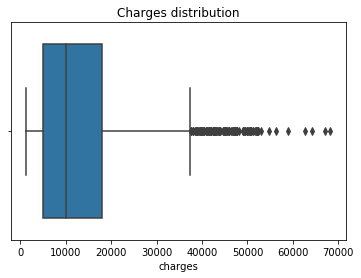

In [48]:
plt.title("Charges distribution")

sns.boxplot(dataframe.charges)

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [49]:
!pip install jovian --upgrade -q

In [50]:
import jovian

In [51]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "ankitgadge250/02-insurance-linear" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/ankitgadge250/02-insurance-linear


'https://jovian.ai/ankitgadge250/02-insurance-linear'

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [109]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [110]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[55.    ,  0.    , 36.0525,  2.    ,  0.    ],
        [64.    ,  1.    , 41.6955,  0.    ,  0.    ],
        [55.    ,  1.    , 41.4865,  3.    ,  0.    ],
        ...,
        [56.    ,  1.    , 28.5285,  0.    ,  0.    ],
        [18.    ,  0.    , 33.3355,  0.    ,  0.    ],
        [43.    ,  1.    , 28.633 ,  0.    ,  0.    ]]),
 array([[13127.4365075],
        [15205.2734665],
        [32168.0311885],
        ...,
        [11946.9968855],
        [ 2357.9974665],
        [ 7315.984509 ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [111]:
inputs = torch.from_numpy(inputs_array)
targets = torch.from_numpy(targets_array)
inputs = inputs.to(torch.float32)
targets = targets.to(torch.float32)
inputs.size(),targets.size()


(torch.Size([1271, 5]), torch.Size([1271, 1]))

In [112]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [113]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [114]:
val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [115]:
batch_size = 150

In [116]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [117]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[31.0000,  0.0000, 41.9045,  1.0000,  1.0000],
        [64.0000,  1.0000, 29.0510,  0.0000,  0.0000],
        [20.0000,  1.0000, 30.7230,  0.0000,  0.0000],
        [35.0000,  0.0000, 39.4460,  2.0000,  0.0000],
        [32.0000,  1.0000, 33.0330,  1.0000,  0.0000],
        [54.0000,  1.0000, 26.4385,  0.0000,  0.0000],
        [40.0000,  0.0000, 36.0525,  2.0000,  1.0000],
        [43.0000,  1.0000, 28.0720,  5.0000,  0.0000],
        [41.0000,  0.0000, 34.7600,  0.0000,  0.0000],
        [38.0000,  1.0000, 32.1860,  2.0000,  0.0000],
        [47.0000,  0.0000, 32.3070,  1.0000,  0.0000],
        [55.0000,  0.0000, 33.1540,  2.0000,  0.0000],
        [41.0000,  1.0000, 26.3340,  1.0000,  0.0000],
        [22.0000,  0.0000, 31.7020,  0.0000,  0.0000],
        [19.0000,  1.0000, 22.3300,  0.0000,  0.0000],
        [18.0000,  0.0000, 36.4705,  0.0000,  0.0000],
        [62.0000,  0.0000, 40.5460,  1.0000,  0.0000],
        [61.0000,  1.0000, 35.5300,  2.0000,  0.0000],
  

        [64.0000,  1.0000, 43.0760,  1.0000,  0.0000]])
targets: tensor([[62671.0508],
        [15402.1768],
        [ 2104.7144],
        [ 6245.0767],
        [ 4359.6655],
        [11152.5205],
        [42803.5664],
        [15491.8135],
        [ 6619.1558],
        [ 6909.8926],
        [ 9146.0293],
        [12713.7070],
        [ 7338.5732],
        [ 2307.7244],
        [ 1329.2181],
        [ 2362.2363],
        [33833.4023],
        [15107.9932],
        [27159.0586],
        [21100.0742],
        [ 9453.7334],
        [ 3465.1262],
        [41104.5586],
        [37041.0898],
        [ 1866.5775],
        [ 2969.4556],
        [ 1893.3989],
        [ 7538.6841],
        [ 6334.5112],
        [11708.0811],
        [20157.4121],
        [ 4137.5352],
        [12871.3369],
        [ 2699.7913],
        [42625.0742],
        [ 3745.6553],
        [ 4531.3721],
        [ 7435.1099],
        [ 3734.8875],
        [15402.0059],
        [13124.0928],
        [ 6505.2485],
        [ 5

Let's save our work by committing to Jovian.

In [118]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "ankitgadge250/02-insurance-linear-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ai/ankitgadge250/02-insurance-linear-regression


'https://jovian.ai/ankitgadge250/02-insurance-linear-regression'

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [119]:
inputs.size(), targets.size()

(torch.Size([1271, 5]), torch.Size([1271, 1]))

In [120]:
input_size = len(input_cols)
output_size = len(output_cols)
input_size,output_size

(5, 1)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [121]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size) # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)     # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)       # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)     # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [122]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [123]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0174,  0.0445,  0.1531, -0.2111,  0.2433]], requires_grad=True),
 Parameter containing:
 tensor([-0.2710], requires_grad=True)]

One final commit before we train the model.

In [124]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "ankitgadge250/02-insurance-linear-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ai/ankitgadge250/02-insurance-linear-regression


'https://jovian.ai/ankitgadge250/02-insurance-linear-regression'

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [125]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [126]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 14905.6015625}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [130]:
epochs = 500
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8152.8965
Epoch [40], val_loss: 8147.3584
Epoch [60], val_loss: 8143.0479
Epoch [80], val_loss: 8138.7314
Epoch [100], val_loss: 8134.6504
Epoch [120], val_loss: 8132.9092
Epoch [140], val_loss: 8131.1260
Epoch [160], val_loss: 8129.5508
Epoch [180], val_loss: 8128.7148
Epoch [200], val_loss: 8127.0146
Epoch [220], val_loss: 8125.9023
Epoch [240], val_loss: 8124.9243
Epoch [260], val_loss: 8123.7944
Epoch [280], val_loss: 8123.2783
Epoch [300], val_loss: 8123.5547
Epoch [320], val_loss: 8123.6611
Epoch [340], val_loss: 8122.4219
Epoch [360], val_loss: 8122.2026
Epoch [380], val_loss: 8122.1226
Epoch [400], val_loss: 8122.6016
Epoch [420], val_loss: 8122.3970
Epoch [440], val_loss: 8122.3398
Epoch [460], val_loss: 8122.5938
Epoch [480], val_loss: 8122.5459
Epoch [500], val_loss: 8122.5498


In [131]:
epochs = 1000
lr = 1e-1
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8124.1777
Epoch [40], val_loss: 8122.0273
Epoch [60], val_loss: 8120.0635
Epoch [80], val_loss: 8117.0762
Epoch [100], val_loss: 8114.5264
Epoch [120], val_loss: 8115.0854
Epoch [140], val_loss: 8114.8716
Epoch [160], val_loss: 8110.7202
Epoch [180], val_loss: 8109.1709
Epoch [200], val_loss: 8106.0723
Epoch [220], val_loss: 8106.4189
Epoch [240], val_loss: 8103.9072
Epoch [260], val_loss: 8099.6572
Epoch [280], val_loss: 8099.0449
Epoch [300], val_loss: 8098.9683
Epoch [320], val_loss: 8100.1035
Epoch [340], val_loss: 8092.9741
Epoch [360], val_loss: 8094.0923
Epoch [380], val_loss: 8090.9790
Epoch [400], val_loss: 8088.8760
Epoch [420], val_loss: 8086.1675
Epoch [440], val_loss: 8085.5620
Epoch [460], val_loss: 8085.6699
Epoch [480], val_loss: 8082.7158
Epoch [500], val_loss: 8080.0312
Epoch [520], val_loss: 8082.7061
Epoch [540], val_loss: 8077.9170
Epoch [560], val_loss: 8075.5005
Epoch [580], val_loss: 8075.1592
Epoch [600], val_loss: 8075.7666
Epoch [620], v

In [132]:
epochs = 5000
lr = 0.1
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8049.2319
Epoch [40], val_loss: 8046.6392
Epoch [60], val_loss: 8046.3408
Epoch [80], val_loss: 8044.6064
Epoch [100], val_loss: 8045.4800
Epoch [120], val_loss: 8042.0112
Epoch [140], val_loss: 8041.4341
Epoch [160], val_loss: 8040.2920
Epoch [180], val_loss: 8038.0977
Epoch [200], val_loss: 8040.8906
Epoch [220], val_loss: 8038.4746
Epoch [240], val_loss: 8038.4575
Epoch [260], val_loss: 8036.2354
Epoch [280], val_loss: 8035.0332
Epoch [300], val_loss: 8031.8154
Epoch [320], val_loss: 8033.0762
Epoch [340], val_loss: 8030.3975
Epoch [360], val_loss: 8030.2871
Epoch [380], val_loss: 8028.4268
Epoch [400], val_loss: 8028.2646
Epoch [420], val_loss: 8025.7896
Epoch [440], val_loss: 8026.2178
Epoch [460], val_loss: 8025.1094
Epoch [480], val_loss: 8026.3052
Epoch [500], val_loss: 8023.1094
Epoch [520], val_loss: 8021.7969
Epoch [540], val_loss: 8019.6680
Epoch [560], val_loss: 8019.4229
Epoch [580], val_loss: 8018.4678
Epoch [600], val_loss: 8016.8853
Epoch [620], v

Epoch [4860], val_loss: 7837.7246
Epoch [4880], val_loss: 7836.6025
Epoch [4900], val_loss: 7835.6035
Epoch [4920], val_loss: 7834.7783
Epoch [4940], val_loss: 7834.2061
Epoch [4960], val_loss: 7833.4629
Epoch [4980], val_loss: 7832.3564
Epoch [5000], val_loss: 7832.0205


In [136]:
epochs = 5000
lr = 1
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6852.8896
Epoch [40], val_loss: 6980.0693
Epoch [60], val_loss: 7061.2515
Epoch [80], val_loss: 6840.8047
Epoch [100], val_loss: 6932.3428
Epoch [120], val_loss: 6832.3735
Epoch [140], val_loss: 6815.3418
Epoch [160], val_loss: 6802.7344
Epoch [180], val_loss: 6791.2139
Epoch [200], val_loss: 6779.4014
Epoch [220], val_loss: 6777.5488
Epoch [240], val_loss: 6774.7070
Epoch [260], val_loss: 6767.6699
Epoch [280], val_loss: 6844.6885
Epoch [300], val_loss: 6752.7490
Epoch [320], val_loss: 6966.3740
Epoch [340], val_loss: 6750.9136
Epoch [360], val_loss: 6721.3760
Epoch [380], val_loss: 6798.1543
Epoch [400], val_loss: 6702.7871
Epoch [420], val_loss: 6750.7607
Epoch [440], val_loss: 6688.6582
Epoch [460], val_loss: 6695.0518
Epoch [480], val_loss: 6735.4551
Epoch [500], val_loss: 6665.0752
Epoch [520], val_loss: 6681.2461
Epoch [540], val_loss: 6672.0049
Epoch [560], val_loss: 6670.1738
Epoch [580], val_loss: 6657.0996
Epoch [600], val_loss: 6672.6309
Epoch [620], v

Epoch [4860], val_loss: 5130.0776
Epoch [4880], val_loss: 5166.1953
Epoch [4900], val_loss: 5373.5400
Epoch [4920], val_loss: 5160.9238
Epoch [4940], val_loss: 5222.9658
Epoch [4960], val_loss: 5182.7246
Epoch [4980], val_loss: 5089.1157
Epoch [5000], val_loss: 5065.5859


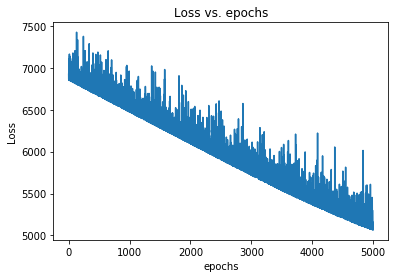

In [139]:
val_loss_list = [loss['val_loss'] for loss in history4]
plt.plot(val_loss_list)
plt.xlabel('epochs')
plt.ylabel('Loss') 
plt.title('Loss vs. epochs')
plt.show()

In [138]:
epochs = 20000
lr = 0.1
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5066.5000
Epoch [40], val_loss: 5065.9492
Epoch [60], val_loss: 5067.1602
Epoch [80], val_loss: 5064.3213
Epoch [100], val_loss: 5064.4492
Epoch [120], val_loss: 5061.6836
Epoch [140], val_loss: 5066.7256
Epoch [160], val_loss: 5061.0664
Epoch [180], val_loss: 5065.3203
Epoch [200], val_loss: 5062.5835
Epoch [220], val_loss: 5058.8721
Epoch [240], val_loss: 5060.2314
Epoch [260], val_loss: 5061.8623
Epoch [280], val_loss: 5058.5674
Epoch [300], val_loss: 5057.5537
Epoch [320], val_loss: 5056.6396
Epoch [340], val_loss: 5057.4795
Epoch [360], val_loss: 5060.5093
Epoch [380], val_loss: 5054.6621
Epoch [400], val_loss: 5054.0723
Epoch [420], val_loss: 5057.1660
Epoch [440], val_loss: 5054.3291
Epoch [460], val_loss: 5053.1240
Epoch [480], val_loss: 5053.0908
Epoch [500], val_loss: 5054.0601
Epoch [520], val_loss: 5057.4844
Epoch [540], val_loss: 5051.6602
Epoch [560], val_loss: 5050.5361
Epoch [580], val_loss: 5050.8901
Epoch [600], val_loss: 5050.5283
Epoch [620], v

Epoch [4860], val_loss: 4950.7651
Epoch [4880], val_loss: 4951.3560
Epoch [4900], val_loss: 4952.7676
Epoch [4920], val_loss: 4949.3354
Epoch [4940], val_loss: 4949.7495
Epoch [4960], val_loss: 4947.6973
Epoch [4980], val_loss: 4946.9551
Epoch [5000], val_loss: 4946.8857
Epoch [5020], val_loss: 4950.6484
Epoch [5040], val_loss: 4952.0176
Epoch [5060], val_loss: 4945.1187
Epoch [5080], val_loss: 4949.8174
Epoch [5100], val_loss: 4947.5195
Epoch [5120], val_loss: 4948.7354
Epoch [5140], val_loss: 4945.6167
Epoch [5160], val_loss: 4943.6909
Epoch [5180], val_loss: 4947.5049
Epoch [5200], val_loss: 4943.5527
Epoch [5220], val_loss: 4944.8472
Epoch [5240], val_loss: 4942.9326
Epoch [5260], val_loss: 4941.0562
Epoch [5280], val_loss: 4942.6489
Epoch [5300], val_loss: 4946.8765
Epoch [5320], val_loss: 4940.9629
Epoch [5340], val_loss: 4938.9507
Epoch [5360], val_loss: 4942.2686
Epoch [5380], val_loss: 4938.4727
Epoch [5400], val_loss: 4938.6821
Epoch [5420], val_loss: 4943.7314
Epoch [5440], 

Epoch [9660], val_loss: 4854.3364
Epoch [9680], val_loss: 4851.5596
Epoch [9700], val_loss: 4853.1675
Epoch [9720], val_loss: 4850.8779
Epoch [9740], val_loss: 4853.7993
Epoch [9760], val_loss: 4851.1094
Epoch [9780], val_loss: 4852.9697
Epoch [9800], val_loss: 4851.7324
Epoch [9820], val_loss: 4847.9604
Epoch [9840], val_loss: 4848.0537
Epoch [9860], val_loss: 4850.4521
Epoch [9880], val_loss: 4853.7910
Epoch [9900], val_loss: 4849.8750
Epoch [9920], val_loss: 4852.1084
Epoch [9940], val_loss: 4851.4229
Epoch [9960], val_loss: 4849.3740
Epoch [9980], val_loss: 4846.0254
Epoch [10000], val_loss: 4848.9414
Epoch [10020], val_loss: 4850.3276
Epoch [10040], val_loss: 4845.3359
Epoch [10060], val_loss: 4850.1191
Epoch [10080], val_loss: 4851.8486
Epoch [10100], val_loss: 4852.0117
Epoch [10120], val_loss: 4845.5591
Epoch [10140], val_loss: 4844.8633
Epoch [10160], val_loss: 4846.3721
Epoch [10180], val_loss: 4851.0957
Epoch [10200], val_loss: 4843.1416
Epoch [10220], val_loss: 4840.6738
Ep

Epoch [14340], val_loss: 4779.8481
Epoch [14360], val_loss: 4778.3281
Epoch [14380], val_loss: 4777.7012
Epoch [14400], val_loss: 4775.9712
Epoch [14420], val_loss: 4777.9795
Epoch [14440], val_loss: 4779.7529
Epoch [14460], val_loss: 4779.0850
Epoch [14480], val_loss: 4775.9858
Epoch [14500], val_loss: 4779.5156
Epoch [14520], val_loss: 4774.3999
Epoch [14540], val_loss: 4775.8066
Epoch [14560], val_loss: 4773.7871
Epoch [14580], val_loss: 4773.1162
Epoch [14600], val_loss: 4772.3701
Epoch [14620], val_loss: 4773.0747
Epoch [14640], val_loss: 4773.7178
Epoch [14660], val_loss: 4775.0254
Epoch [14680], val_loss: 4775.0928
Epoch [14700], val_loss: 4778.1538
Epoch [14720], val_loss: 4774.4688
Epoch [14740], val_loss: 4772.1025
Epoch [14760], val_loss: 4773.6680
Epoch [14780], val_loss: 4771.7100
Epoch [14800], val_loss: 4771.9961
Epoch [14820], val_loss: 4772.7969
Epoch [14840], val_loss: 4771.0762
Epoch [14860], val_loss: 4770.0713
Epoch [14880], val_loss: 4769.3599
Epoch [14900], val_l

Epoch [19020], val_loss: 4721.1807
Epoch [19040], val_loss: 4723.3984
Epoch [19060], val_loss: 4719.1055
Epoch [19080], val_loss: 4721.6416
Epoch [19100], val_loss: 4723.8467
Epoch [19120], val_loss: 4717.8560
Epoch [19140], val_loss: 4719.2207
Epoch [19160], val_loss: 4719.3145
Epoch [19180], val_loss: 4718.2109
Epoch [19200], val_loss: 4717.5967
Epoch [19220], val_loss: 4717.2383
Epoch [19240], val_loss: 4717.0059
Epoch [19260], val_loss: 4719.9419
Epoch [19280], val_loss: 4716.2251
Epoch [19300], val_loss: 4716.3711
Epoch [19320], val_loss: 4715.8457
Epoch [19340], val_loss: 4717.0474
Epoch [19360], val_loss: 4717.5396
Epoch [19380], val_loss: 4715.8052
Epoch [19400], val_loss: 4715.7637
Epoch [19420], val_loss: 4716.5435
Epoch [19440], val_loss: 4714.0791
Epoch [19460], val_loss: 4716.6660
Epoch [19480], val_loss: 4714.7471
Epoch [19500], val_loss: 4715.2344
Epoch [19520], val_loss: 4714.3403
Epoch [19540], val_loss: 4714.5781
Epoch [19560], val_loss: 4713.8760
Epoch [19580], val_l

**Q: What is the final validation loss of your model?**

In [140]:
val_loss = history5[-1]['val_loss']
val_loss

4710.8662109375

Let's log the final validation loss to Jovian and commit the notebook

In [141]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [142]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "ankitgadge250/02-insurance-linear-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/ankitgadge250/02-insurance-linear-regression


'https://jovian.ai/ankitgadge250/02-insurance-linear-regression'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [143]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [144]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([57.0000,  0.0000, 22.1100,  1.0000,  0.0000])
Target: tensor([12874.5889])
Prediction: tensor([12846.8379])


In [145]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([24.0000,  1.0000, 39.4460,  0.0000,  0.0000])
Target: tensor([2126.0188])
Prediction: tensor([2750.3557])


In [146]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([52.0000,  0.0000, 34.9030,  2.0000,  0.0000])
Target: tensor([11970.7930])
Prediction: tensor([11795.0361])


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to replicate this notebook for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patterns in machine learning from problem-specific details.You can use one of these starer notebooks (just change the dataset):

- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ai/forum/t/linear-regression-and-logistic-regression-notebooks-and-blog-posts/14039

In [147]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "ankitgadge250/02-insurance-linear-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/ankitgadge250/02-insurance-linear-regression


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "ankitgadge250/02-insurance-linear-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/ankitgadge250/02-insurance-linear-regression


'https://jovian.ai/ankitgadge250/02-insurance-linear-regression'

In [148]:
jovian.submit(assignment="zerotogans-a2")

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "ankitgadge250/02-insurance-linear-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/ankitgadge250/02-insurance-linear-regression
[jovian] Submitting assignment..
[jovian] Verify your submission at https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model
